In [1]:
import re
import nltk
from nltk.corpus import stopwords

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten
from keras.layers import GlobalMaxPooling1D
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

In [2]:
#Load Data
import pandas as pd

df = pd.read_excel("../Research Data/Final_Dataset.xlsx")

df.isnull().values.any()

df.shape

(247715, 19)

In [85]:
df.isnull().values.any()

False

In [3]:
import numpy as np

In [4]:
df = df.drop(['Unnamed: 0'], axis = 1)

In [5]:
df = df.round(2)

In [6]:
#Function to find the initial sentimental score
def senti(row):
    if row['Star_Rating'] <= 2:
        val = 'Negative'
    elif row['Star_Rating'] == 3:
        val = 'Neutral'
    else:
        val = 'Positive' 
    return val

In [7]:
#Add index to dataframe
df['Sentiment'] = df.apply(senti, axis=1)

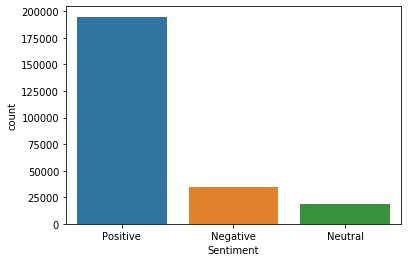

In [8]:
import seaborn as sns

sns.countplot(x='Sentiment', data=df)

In [9]:
#select relavant columns
review_df = df[['Review_Body','Sentiment']]

In [11]:
review_df = review_df[review_df['Sentiment'] != 'Neutral']

In [13]:
# convert airline_seentiment to numeric
sentiment_label = review_df.Sentiment.factorize()

In [17]:
sentiment_label

(array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 Index(['Positive', 'Negative'], dtype='object'))

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
review = review_df.Review_Body.values
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(review)
vocab_size = len(tokenizer.word_index) + 1
encoded_docs = tokenizer.texts_to_sequences(review)
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

In [22]:
print(padded_sequence[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   29   33  388    3   21  140 1214  226    2  700   38   23
  543   23    2  108   38   28  105   20   18    5 2050  114   42   40
  131  293  352  154   36  207  226  105 2495    5   71   17   10    1
   65   43    5   30   92    2   41  611 1586  528  171  759 1214 3232
 2385 

In [24]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.layers import Embedding
embedding_vector_length = 32
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length,     
                                     input_length=200) )
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', 
                           metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           1948000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 50)                16600     
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 1,964,651
Trainable params: 1,964,651
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
history = model.fit(padded_sequence,sentiment_label[0],
                  validation_split=0.2, epochs=5, batch_size=32)

Epoch 1/5
5739/5739 [==============================] - 1544s 269ms/step - loss: 0.1877 - accuracy: 0.9276 - val_loss: 0.1505 - val_accuracy: 0.9406
Epoch 2/5
5739/5739 [==============================] - 1459s 254ms/step - loss: 0.1355 - accuracy: 0.9485 - val_loss: 0.1368 - val_accuracy: 0.9497
Epoch 3/5
5739/5739 [==============================] - 1439s 251ms/step - loss: 0.1222 - accuracy: 0.9541 - val_loss: 0.1185 - val_accuracy: 0.9554
Epoch 4/5
5739/5739 [==============================] - 1443s 251ms/step - loss: 0.1143 - accuracy: 0.9572 - val_loss: 0.1167 - val_accuracy: 0.9568
Epoch 5/5
5739/5739 [==============================] - 1451s 253ms/step - loss: 0.1082 - accuracy: 0.9596 - val_loss: 0.1144 - val_accuracy: 0.9581


In [27]:
score = model.evaluate(padded_sequence, sentiment_label[0], verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

7174/7174 [==============================] - 157s 22ms/step - loss: 0.0928 - accuracy: 0.9660
Test Score: 0.09278108924627304
Test Accuracy: 0.9660458564758301


In [31]:
history

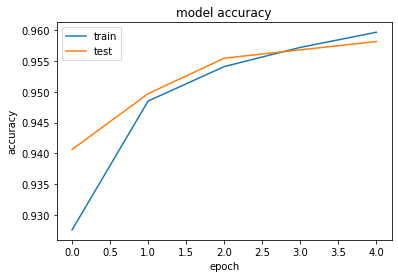

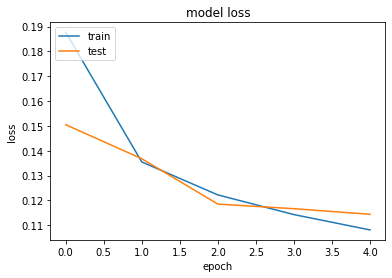

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [88]:
test_word ="this was extremely amazing"
tw = tokenizer.texts_to_sequences([test_word])
tw = pad_sequences(tw,maxlen=200)
prediction = model.predict(tw)
prediction

array([[0.00240222]], dtype=float32)

In [89]:
test_score = convert_sent(prediction[0][0])
test_score

0.9951955624856055

In [59]:
def convert_sent(score):
    OldValue = score
    OldRange = (1 - 0)
    if (OldRange == 0):
        NewValue = (-1)
    else:
        NewRange = (1 - (-1))  
        NewValue = (((OldValue - 0) * NewRange) / OldRange) + (-1)
        NewValue *= -1
    return NewValue

In [60]:
sent_score = []
for row in df['Review_Body']:
    tw = tokenizer.texts_to_sequences([row])
    tw = pad_sequences(tw,maxlen=200)
    prediction = model.predict(tw)
    temp_score = convert_sent(prediction[0][0])
    sent_score.append(temp_score)

In [61]:
sent_score

[0.9976568617857993,
 0.9984378187218681,
 0.9964019313920289,
 -0.9952462911605835,
 0.9986601963173598,
 0.9964332892559469,
 0.9980213278904557,
 -0.9936667680740356,
 0.9902246166020632,
 -0.8479980230331421,
 0.9891598941758275,
 0.9992346537183039,
 -0.3135509490966797,
 0.9990006746957079,
 0.5673888921737671,
 0.9984031587373465,
 -0.843921422958374,
 0.9989034445025027,
 0.9989170167827979,
 0.9972511713858694,
 0.9850139990448952,
 0.9853857234120369,
 0.9817430227994919,
 0.9991144444211386,
 -0.9951890707015991,
 0.9992912293528207,
 0.8764746561646461,
 0.9950444092974067,
 0.9990910237538628,
 0.9992267601191998,
 0.9991277624503709,
 0.9993299407651648,
 0.9995810179389082,
 -0.9601763486862183,
 0.9988937607267871,
 0.9979220994282514,
 0.9982239729724824,
 0.999054980056826,
 0.998959225951694,
 0.9991358687984757,
 0.9880996840074658,
 0.9969276343472302,
 0.9993087496841326,
 -0.9720011949539185,
 0.9994056876166724,
 0.9977464603725821,
 0.9990664926008321,
 -0.9982

In [62]:
df

,Customer_Id,Product_Id,Review_ID,Product_Category,Star_Rating,Helpful_Votes,Total_Votes,Review_Headline,Review_Body,Review_Date,Helpfulness_Index,Index_Avg,Activity,Reputation,Helpfulness_Label,Text_Length,Order,Time Interval,Sentiment
0,3575256,B00RFM5984,R1BP7IWCZE6FQY,Beauty,5,1,4,beauty on a budget,love these brushes and very soft foundation br...,2015-05-29,0.25,0.12,5,0.62,0,60,45,1,Positive
1,45940035,B00L83AI2S,RKHOFMRPS9OIQ,Beauty,5,33,36,A Very Good Product for Skin Pickers,I don't suffer from acne. However I suffer fro...,2015-04-04,0.92,0.92,1,0.92,1,168,28,3,Positive
2,21057750,B00NW3O83C,RCFGZCIQOB29J,Sports,5,0,0,Five Stars,Great socks!!,2015-07-20,0.00,0.00,6,0.00,0,2,4,12,Positive
3,46444139,B00GABH5A6,R1RF0L40KNRM1V,Home,1,0,3,Not happy. No instructions or even a name of ...,I got absolutely no instructions with my vinyl...,2015-08-29,0.00,0.00,8,0.00,0,125,1,7,Negative
4,22816847,B00UKOD896,ROSQVAVJNA83W,Sports,4,0,0,Great Quality for the Price,These pliers are a great find for fishermen. T...,2015-07-09,0.00,0.00,1,0.00,0,69,6,0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247710,46898081,B00QI1ALXQ,RDNXNF127V8L6,Home,5,0,0,Five Stars,Product as promised.,2015-05-15,0.00,0.00,8,0.00,0,3,57,0,Positive
247711,11816784,B002OCYG84,R2M0518IKW1FDF,Sports,2,16,18,but the combo is horrible. I bought this to mo...,"Locks securely, but the combo is horrible. I ...",2015-07-22,0.89,0.89,2,1.78,1,222,5,10,Negative
247712,48431538,B00RMX70NS,RY15HL7LVEM0C,Grocery,5,1,1,"i totally LOVE it, at last i can enjoy my coff...","i totally LOVE it,at last i can enjoy my coffe...",2015-02-18,1.00,1.00,2,2.00,1,30,16,1,Positive
247713,16468356,B00QGM9D4K,R1L2V4PZRHURZF,Beauty,5,0,0,Product as described.,Amazing smell. Arrived before ETA. Really sati...,2015-08-18,0.00,0.00,3,0.00,0,10,2,4,Positive


In [64]:
sent_df = df.insert(19, 'Sentiment_Score', sent_score)

In [66]:
sent_df

In [67]:
df

,Customer_Id,Product_Id,Review_ID,Product_Category,Star_Rating,Helpful_Votes,Total_Votes,Review_Headline,Review_Body,Review_Date,Helpfulness_Index,Index_Avg,Activity,Reputation,Helpfulness_Label,Text_Length,Order,Time Interval,Sentiment,Sentiment_Score
0,3575256,B00RFM5984,R1BP7IWCZE6FQY,Beauty,5,1,4,beauty on a budget,love these brushes and very soft foundation br...,2015-05-29,0.25,0.12,5,0.62,0,60,45,1,Positive,0.997657
1,45940035,B00L83AI2S,RKHOFMRPS9OIQ,Beauty,5,33,36,A Very Good Product for Skin Pickers,I don't suffer from acne. However I suffer fro...,2015-04-04,0.92,0.92,1,0.92,1,168,28,3,Positive,0.998438
2,21057750,B00NW3O83C,RCFGZCIQOB29J,Sports,5,0,0,Five Stars,Great socks!!,2015-07-20,0.00,0.00,6,0.00,0,2,4,12,Positive,0.996402
3,46444139,B00GABH5A6,R1RF0L40KNRM1V,Home,1,0,3,Not happy. No instructions or even a name of ...,I got absolutely no instructions with my vinyl...,2015-08-29,0.00,0.00,8,0.00,0,125,1,7,Negative,-0.995246
4,22816847,B00UKOD896,ROSQVAVJNA83W,Sports,4,0,0,Great Quality for the Price,These pliers are a great find for fishermen. T...,2015-07-09,0.00,0.00,1,0.00,0,69,6,0,Positive,0.998660
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247710,46898081,B00QI1ALXQ,RDNXNF127V8L6,Home,5,0,0,Five Stars,Product as promised.,2015-05-15,0.00,0.00,8,0.00,0,3,57,0,Positive,0.979169
247711,11816784,B002OCYG84,R2M0518IKW1FDF,Sports,2,16,18,but the combo is horrible. I bought this to mo...,"Locks securely, but the combo is horrible. I ...",2015-07-22,0.89,0.89,2,1.78,1,222,5,10,Negative,0.977609
247712,48431538,B00RMX70NS,RY15HL7LVEM0C,Grocery,5,1,1,"i totally LOVE it, at last i can enjoy my coff...","i totally LOVE it,at last i can enjoy my coffe...",2015-02-18,1.00,1.00,2,2.00,1,30,16,1,Positive,0.999023
247713,16468356,B00QGM9D4K,R1L2V4PZRHURZF,Beauty,5,0,0,Product as described.,Amazing smell. Arrived before ETA. Really sati...,2015-08-18,0.00,0.00,3,0.00,0,10,2,4,Positive,0.999621


In [69]:
df['Sentiment_Score'].mean()

0.6597075875026936

In [72]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter('Senti_data.xlsx', engine='xlsxwriter')

# Don't convert url-like strings to urls.
writer.book.strings_to_urls = False

# Convert the dataframe to an XlsxWriter Excel object.
df.to_excel(writer, sheet_name='Reviews', index = False)

# Close the Pandas Excel writer and output the Excel file.
writer.save()